<center>
Reinforcement Learning
    
Practice 8 - Policy Gradient
</center>

The purpose of this project is to study different properties of Policy Gradient algorithms with Function Approximation.

In [1]:
# You are allowed to use the following modules
import numpy as np
import matplotlib.pyplot as plt
import gym


## Description

In this HW, you will be implementing an Actor-Critic algorithm with Fourier function approximation and apply it to the following problems:

- Mountain Car `gym.make('MountainCar-v0')`
- Cart Pole `gym.make('CartPole-v1')`


## Part-I
Implement ACTOR-CRITIC with Eligibility Trace (p. 332).



In [231]:
# Your code here

def sigmoid(z):
    return 1/(1 + np.exp(-z))

class ActorCritic:
    def __init__(self,env,order,alpha_t,alpha_w,lambda_t,lambda_w,gamma,fourier_coeff,high,low,create_env) -> None:
        self.x = None
        self.prob = None
        self.episode_step = None
        self.episode_reward = None
        self.high = high
        self.low = low
        self.a = None
        self.s = None
        self.alpha_t = alpha_t
        self.alpha_w = alpha_w
        self.lambda_t = lambda_t
        self.lambda_w = lambda_w
        self.gamma = gamma
        self.order=order
        self.coeff = fourier_coeff
        # np.array([[i,j] for i in range(self.order+1) for j in range(self.order+1)])
        self.env = env
        self.env.reset()
        self.action_size = self.env.action_space.n
        self.state_size = self.env.observation_space.shape[0]
        self.theta_init= np.zeros(self.action_size*(order+1)**self.state_size)
        self.theta = self.theta_init
        self.create_env=create_env
        if self.create_env == 'CartPole-v1':
            self.low = sigmoid(low)
            self.high = sigmoid(high)

    
    def softmax(self):
        exp_h = np.zeros(self.action_size)
        for i in range(0,self.action_size):
            exp_h[i] = np.exp(self.h_estimate(i))
        # print(exp_h)
        # exp_h = exp_h - np.max(exp_h)
        # exp_h = np.exp(exp_h)
        # print('after:',exp_h)
        self.prob = exp_h/np.sum(exp_h)
        if np.isnan(self.prob).any():
            self.prob = np.repeat(1/self.action_size,self.action_size)
            return self.prob
        return self.prob

    def state_features(self,s):
        return np.cos(np.pi*np.matmul(s,self.coeff.transpose()))

    def feature_vector(self):
        self.x = np.cos(np.pi*np.matmul(self.s,self.coeff.transpose()))
        return self.x

    def h_estimate(self,i): # h=theta^T*X(S,A)
        return np.matmul(self.theta, self._feature_zeropadding(i))

    def nabla_ln(self):
        expected = 0
        probs = self.softmax()
        for b in range(0, self.action_size):
            expected += probs[b] * self._feature_zeropadding(b)
        return self._feature_zeropadding(self.a) - expected

    def _feature_zeropadding(self, a):
        padded = np.zeros([self.action_size, self.coeff.shape[0]])
        padded[a] = self.feature_vector()
        return padded.flatten()

    def act_select(self):
        return np.random.choice(range(0, self.action_size), p=self.softmax())

    def state_normalize(self,state):
        if self.create_env == 'CartPole-v1':
            state = sigmoid(state)
        state = (state - self.low) / (self.high-self.low)
        return state

    def actor_critic(self,runs,episodes):
        self.episode_reward = np.zeros((runs, episodes))
        self.episode_step = np.zeros((runs, episodes))
        for run in range(runs):
            self.theta = self.theta_init
            w = np.zeros(self.coeff.shape[0])
            for episode in range(episodes):
                if (run == runs-1) and (episode == episodes-1):
                    self.env=gym.make(self.create_env,render_mode="human")
                S, info = self.env.reset()
                S = self.state_normalize(S)
                self.s = S

                z_t=np.zeros(self.theta.shape)
                z_w=np.zeros(self.coeff.shape[0])
                I = 1
                step = 0
                rew = 0
                while True:
                    A = self.act_select()
                    self.a = A
                    S_next, reward, terminated, truncated, info = self.env.step(A)
                    rew += reward
                    S_next = self.state_normalize(S_next)
                    v_next = np.matmul(w, self.state_features(S_next))
                    if terminated:
                        v_next = 0
                    delta = reward + self.gamma*v_next-np.matmul(w, self.state_features(S))
                    z_w = self.gamma*self.lambda_w*z_w + self.state_features(S)
                    z_t = self.gamma*self.lambda_t*z_t + I * self.nabla_ln()
                    w += self.alpha_w*delta*z_w
                    self.theta += self.alpha_t*delta*z_t
                    I = self.gamma*I
                    S = S_next
                    self.s = S
                    step += 1
                    # if step%5==0:
                    #     print(self.theta)
                    if terminated or (self.create_env == 'CartPole-v1' and truncated):
                        break
                self.episode_reward[run, episode] = rew
                self.episode_step[run, episode] = step

    def get_theta(self):
        return self.theta

    def reward_plot(self):
        plt.figure(1, (10, 6))
        plt.title(self.create_env)
        plt.plot(range(len(self.episode_reward[0, :])), np.mean(self.episode_reward, 0))
        plt.xlabel('Episodes')
        plt.ylabel('Sum of rewards during episode')
        # plt.ylim([-300,20])
        # plt.legend()
        plt.grid()
        plt.show()

    def step_plot(self):
        plt.figure(2, (10, 6))
        plt.title(self.create_env)
        plt.plot(range(len(self.episode_step[0, :])), np.log10(np.mean(self.episode_step, 0)))
        plt.xlabel('Episodes')
        plt.ylabel('steps during episode(log_scale)')
        # plt.ylim([-200,10])
        # plt.legend()
        plt.grid()
        plt.show()


## Part II

Use the algorithm to learn both tasks. Tune the step-size parameter ($\alpha$), the Function Approximation order, the discount factor ($\gamma$), and the $\lambda$-value. **Note:** you can consider the problem to be undiscounted.

For each task:
 
1. Plot step-per-episode (in log scale) vs. number of episodes. This plot should be averaged over 50-100 runs. 
2. Plot total reward on episode vs. number of episodes. This plot should be averaged over 50-100 runs.
3. Show an animation of the task for the final episode.


In [234]:
######## mountain_car ##########
env = gym.make('MountainCar-v0')
create_env='MountainCar-v0'
high = env.observation_space.high
low = env.observation_space.low
order = 3
fourier_coeff = np.array([[i,j] for i in range(order+1) for j in range(order+1)])
alpha_t = .001
alpha_w = .001
lambda_t = 0.8
lambda_w = 0.8
gamma = 1
runs=50
episodes = 200

instance_mountaincar = ActorCritic(env,order,alpha_t,alpha_w,lambda_t,lambda_w,gamma,fourier_coeff,high,low,create_env)
instance_mountaincar.actor_critic(runs,episodes)

################# cartpole ###############

env= gym.make('CartPole-v1')
create_env='CartPole-v1'
high = env.observation_space.high
low = env.observation_space.low
order = 2
fourier_coeff =  np.array([[i,j,l,m] for i in range(order+1) for j in range(order+1)
                           for l in range(order+1) for m in range(order+1)])
alpha_t = 2**-8
alpha_w = 2**-8
lambda_t = 0.55
lambda_w = 0.55
gamma = 1
runs=20
episodes = 100

instance_cartpole = ActorCritic(env,order,alpha_t,alpha_w,lambda_t,lambda_w,gamma,fourier_coeff,high,low,create_env)
instance_cartpole.actor_critic(runs,episodes)

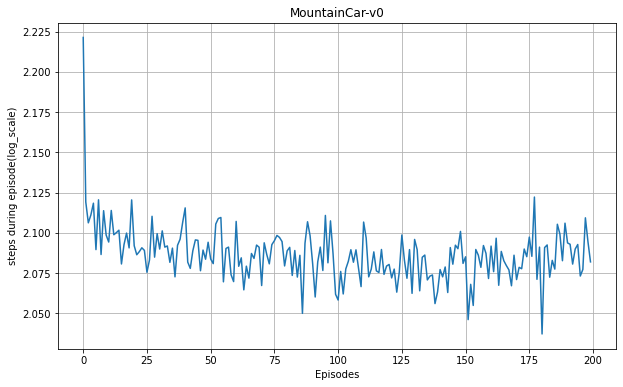

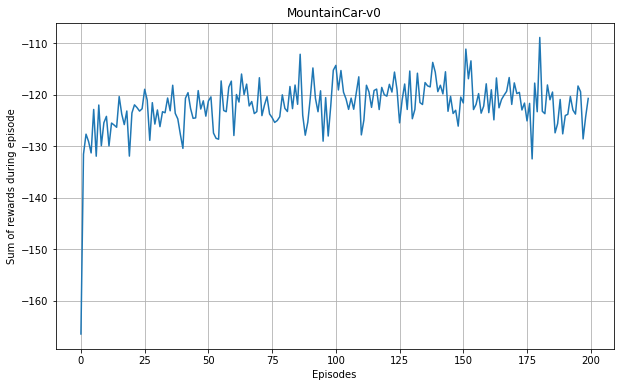

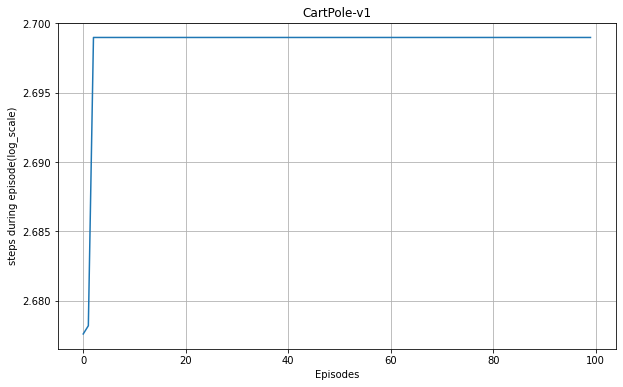

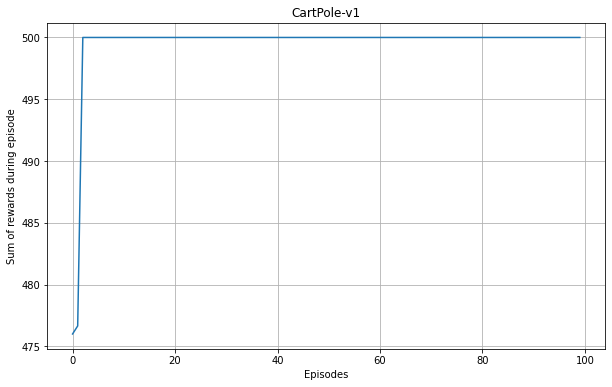

In [235]:
# Your code here

instance_mountaincar.step_plot()
instance_mountaincar.reward_plot()

instance_cartpole.step_plot()
instance_cartpole.reward_plot()

**Comments on the cartpole environment:** I used the sigmoid function to bind the environment in order to remove the $\inf$ value. However, the pole holds up for many steps without terminating an episode. Therefore, I truncated the step after a certain limit.